In [1]:
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"

###################
# Load other relevant libraries
##################
import fsl.wrappers, statsmodels
from fsl.wrappers import fslmaths
import dipy
import os.path as op
import nibabel as nib
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from nilearn import plotting
from sklearn.decomposition import FastICA, PCA

In [3]:
# Loading data, preprocessed data (smoothed) as fmri_img

In [2]:
# organisation of directory and creation of preprocessing folders
dataset_id = 'subject101410'
subject = '101410' 

sample_path = "/home/jovyan/data"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)



###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-101410'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'fmap')) 

In [5]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-101410_task-motor_concat_varnorm.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.par
|--------------- sub-101410_task-motor_concat_varnorm_moco_smoothed-6mm.nii.gz
|--------------- sub-101410_task-motor_func2anat.nii.gz
|--------------- tfMRI_MOTOR_LR_varnorm.nii.gz
|--------------

In [3]:
# get preprocessed fMRI image

smoothed_path = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm_moco_smoothed-6mm.nii.gz")
fmri_img = nib.load(smoothed_path)

In [7]:
# Apply ICA on the subject fMRI runs, considering one volume as one sample.

In [4]:
#  prepare data
data = np.asanyarray(fmri_img.dataobj)
affine = fmri_img.affine
# Calculate the mean across columns
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]

x,y,z,n_vol = data.shape

print(data.shape)

(91, 109, 91, 568)


In [5]:
# slice_non_background = data[:,:,:,0] != 0
# Vectorize : Taking only non-zero voxels into a vector 
# (NOTE: that the order is important)
# samples = data[slice_non_background]
# print("samples size: ", samples.shape)

samples size:  (473171, 568)


In [5]:
# prepare ICA input matrix 


# spatial_means = np.mean(samples, axis=1)
# Row means copied n_vols times so that we substract for each timepoint the spatial mean
# row_means = np.outer(spatial_means, np.ones(n_vols))
# Subtract the means for each row, put the result into X
# X = samples - row_means
# Verify that the spatial mean behaves as expected after substraction
X = np.reshape(data,[x*y*z, n_vol])

print("X matrix size: ", X.shape)

X matrix size:  (902629, 568)


In [6]:
print(np.isnan(X).any()) # nan to 0s


False


In [50]:
#* Run FastICA on X -- check 

S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [7] #10]#20, 60 ...]

for n in nb_components:
    print(f"Processing component {n}")
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)

    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)

    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_

    print("Done")


Processing component 7
Running FastICA with n = 7 components
(902629, 7)
Done


In [48]:
print("The shape of the estimated Sources is: {}".format(S_.shape))
print(np.max(S_dict[60]))

The shape of the estimated Sources is: (902629, 60)
44.39512


In [23]:
#* Read T1-weighted template
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map, show
import matplotlib.pyplot as plt

betted_brain_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz')
T1w_img = nib.load(op.join(betted_brain_path))

mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask.nii.gz')
mask_img = nib.load(mask_path)
from nilearn.image import resample_to_img

# Resample the mask once to match your functional image
resampled_mask = resample_to_img(mask_img, fmri_img, interpolation='nearest')

# Now use it safely with the same affine and shape as your fMRI data
masker = NiftiMasker(mask_img=resampled_mask)


In [ ]:
#* Plot the group-level independent components for the different number of requested components.
## Here you can use only 3 components to reduce the plots
## e.g. uncomment this if you used more than 3 values before
# nb_components = nb_components[:3]
save_results = "/home/jovyan/data/results"

for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="z", cut_coords =[-36,-15,0,20,44,60], title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()
        

In [41]:
# Count rows where all values are the same across columns
S_ = S_dict[20]
same_value_rows = np.all(np.isclose(S_, S_[:, [0]]), axis=1)
n_same_value_rows = np.sum(same_value_rows)

print(f"Rows with identical values across all components: {n_same_value_rows} / {S_.shape[0]} "
      f"({100 * n_same_value_rows / S_.shape[0]:.2f}% of all voxels)")

Rows with identical values across all components: 0 / 902629 (0.00% of all voxels)



Number of components: 7


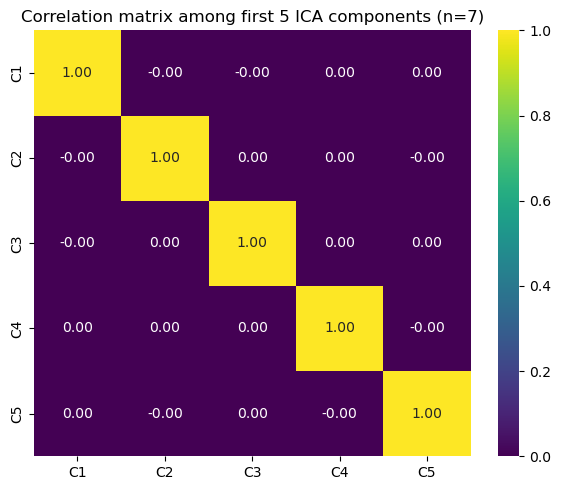

In [53]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

for n in nb_components:
    print(f"\nNumber of components: {n}")
    S_ = S_dict[n].copy()
    
    # Take first 5 components
    n_comp = min(5, S_.shape[1])
    S_subset = S_[:, :n_comp]
    
    # Compute cosine similarity
    sim_matrix = np.corrcoef(S_subset.T)
    
    # Display as a heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=[f"C{i+1}" for i in range(n_comp)],
                yticklabels=[f"C{i+1}" for i in range(n_comp)])
    plt.title(f"Correlation matrix among first {n_comp} ICA components (n={n})")
    plt.tight_layout()
    plt.show()
